# GANs for finance time series simulation 

Framework for generating synthetic time series simulation based on the standard version of 10 GANs

### Setup

In [53]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
# # To generate GIFs, optional
# !pip install imageio
# !pip install git+https://github.com/tensorflow/docs

In [55]:
import glob
import imageio
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
import tensorflow_addons as tfa

import warnings
warnings.filterwarnings("ignore")

from IPython import display
tf.__version__

'2.12.0'

### Load and prepare the dataset

In [56]:
# Specific for real data
BUFFER_SIZE = 5100 # lenght of timeseries 
BATCH_SIZE = 32 
data_dim = 32 
noise_dim = 100
data_channel = 1

In [57]:
# must be from ['dcgan', 'lsgan', 'wgan', 'wgan_gp', 'dragan', 'ragan', 'ralsgan']
# 'dcgan': standard deep convolutional GAN
# 'lsgan': least square GAN, a loss variant
# 'wgan': Wasserstein GAN, a loss variant
# 'wgan_gp': Wasserstein GAN with gradient penalty, a loss variant
# 'dragan': deep regret analytic GAN, a loss variant similar to 'wgan_gp'
# 'ragan', 'ralsgan': loss function improvements of 'dcgan' and 'lsgan' with realistic factors

choice = 'dcgan'

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

In [58]:
# G and D blocks without residual layers
def G_single_block(model, out_channels, g_kernel, act, **kwargs):
    model.add(layers.BatchNormalization())
    model.add(act())
    model.add(layers.Conv1DTranspose(out_channels, g_kernel, strides=2, padding='same', **kwargs))

def D_single_block(model, out_channels, d_kernel, **kwargs):
    model.add(layers.Conv1D(out_channels, d_kernel, strides=2, padding='same', use_bias=False, **kwargs))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

### The Generator

In [59]:
def make_generator_model(choice = 'dcgan'):  
    if choice in ['lsgan', 'dcgan', 'wgan_gp', 'dragan', 'ragan', 'ralsgan']:
        g_kernel = 5
        gf_dim = 32
        act = layers.LeakyReLU

        model = tf.keras.Sequential()
        model.add(layers.Dense(data_dim * gf_dim, input_shape=(noise_dim,)))
        model.add(layers.Reshape((data_dim//8, gf_dim*8)))

        G_single_block(model, gf_dim*4, g_kernel, act)
        G_single_block(model, gf_dim*2, g_kernel, act)
        G_single_block(model, gf_dim, g_kernel, act)
        
        model.add(layers.BatchNormalization())
        model.add(act())
        model.add(layers.Conv1DTranspose(data_channel, g_kernel, strides=1, padding='same', activation= 'linear'))

    elif choice == 'wgan':
        g_kernel = 5
        gf_dim = 32
        act = layers.LeakyReLU
        additional = {'kernel_initializer': tf.random_normal_initializer(stddev=0.02)}

        model = tf.keras.Sequential()
        model.add(layers.Dense(data_dim * gf_dim, input_shape=(noise_dim,), **additional))
        model.add(layers.Reshape((data_dim//8, gf_dim*8)))

        G_single_block(model, gf_dim*4, g_kernel, act, **additional)
        G_single_block(model, gf_dim*2, g_kernel, act, **additional)
        G_single_block(model, gf_dim, g_kernel, act, **additional)
        
        model.add(layers.BatchNormalization())
        model.add(act())
        model.add(layers.Conv1DTranspose(data_channel, g_kernel, strides=1, padding='same', activation= 'linear', **additional))
    
    return model

Use the (as yet untrained) generator to create an image.

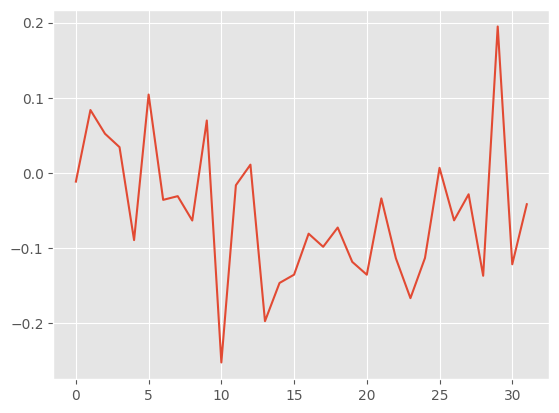

In [60]:
generator = make_generator_model(choice)

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.plot(generated_image[0, :, 0])

In [61]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1024)              103424    
                                                                 
 reshape_1 (Reshape)         (None, 4, 256)            0         
                                                                 
 batch_normalization_6 (Batc  (None, 4, 256)           1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 4, 256)            0         
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 8, 128)           163968    
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 8, 128)          

### The Discriminator

The discriminator is a CNN-based image classifier.

In [62]:
def make_discriminator_model(choice = 'dcgan'):

    if choice in ['lsgan', 'dcgan', 'wgan_gp', 'dragan', 'ragan', 'ralsgan']:
        d_kernel = 5
        df_dim = 32

        model = tf.keras.Sequential()
        model.add(layers.InputLayer(input_shape=(data_dim, data_channel)))
        model.add(layers.Conv1D(df_dim, d_kernel, strides=2, padding='same'))
        model.add(layers.LeakyReLU())

        D_single_block(model, df_dim*2, d_kernel)
        D_single_block(model, df_dim*4, d_kernel)
        
        model.add(layers.Flatten())
        model.add(layers.Dense(1, use_bias=False))

    elif choice == 'wgan':
        d_kernel = 5
        df_dim = 32
        additional = {'kernel_initializer': tf.random_normal_initializer(stddev=0.02),
                'kernel_constraint': lambda w: tf.clip_by_value(w,-0.01,0.01)}

        model = tf.keras.Sequential()
        model.add(layers.InputLayer(input_shape=(data_dim, data_channel)))
        model.add(layers.Conv1D(df_dim, d_kernel, strides=2, padding='same', **additional))
        model.add(layers.LeakyReLU())

        D_single_block(model, df_dim*2, d_kernel, **additional)
        D_single_block(model, df_dim*4, d_kernel, **additional)
        
        model.add(layers.Flatten())
        model.add(layers.Dense(1, use_bias=False, **additional))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [63]:
discriminator = make_discriminator_model(choice)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00078318]], shape=(1, 1), dtype=float32)


In [64]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 16, 32)            192       
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 32)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 8, 64)             10240     
                                                                 
 batch_normalization_10 (Bat  (None, 8, 64)            256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 8, 64)             0         
                                                                 
 conv1d_5 (Conv1D)           (None, 4, 128)            40960     
                                                      

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [65]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def ls_loss(a,b):
  return tf.reduce_mean(tf.nn.l2_loss(a - b)) 

### Discriminator loss


In [66]:
def discriminator_loss(real_output, fake_output, choice = 'dcgan', generated_images = None, images= None):
    if choice == 'lsgan': # LS loss
        real_loss = ls_loss(tf.ones_like(real_output), real_output) 
        fake_loss = ls_loss(-tf.ones_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
    elif choice == 'dcgan': # standard loss
        real_loss = cross_entropy(tf.ones_like(real_output), real_output) 
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
    elif choice == 'ragan': # realistic loss
        real_loss = cross_entropy(tf.ones_like(real_output), real_output - tf.reduce_mean(fake_output)) 
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output - tf.reduce_mean(real_output))
        total_loss = real_loss + fake_loss
    elif choice == 'ralsgan':
        real_loss = ls_loss(tf.ones_like(real_output), real_output - tf.reduce_mean(fake_output)) 
        fake_loss = ls_loss(-tf.ones_like(fake_output), fake_output - tf.reduce_mean(real_output))
        total_loss = real_loss + fake_loss
    elif choice == 'wgan':
        real_loss = -tf.reduce_mean(real_output)
        fake_loss = tf.reduce_mean(fake_output)
        total_loss = real_loss + fake_loss
    elif choice == 'wgan_gp':
        real_loss = -tf.reduce_mean(real_output)
        fake_loss = tf.reduce_mean(fake_output)

        alpha = tf.random.uniform([images.shape[0],1,1])
        interpolates = alpha*images + ((1-alpha)*generated_images)
        disc_interpolates = discriminator(interpolates, training=True)
        gradients = tf.gradients(disc_interpolates, interpolates)[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
        gradient_penalty = tf.reduce_mean((slopes-1)**2)
        lam = 10
        total_loss = real_loss + fake_loss + lam*gradient_penalty

    elif choice == 'dragan':
        real_loss = cross_entropy(tf.ones_like(real_output), real_output) 
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) 

        alpha = tf.random.uniform([images.shape[0],1,1])
        interpolates = alpha*images + ((1-alpha)*generated_images)
        disc_interpolates = discriminator(interpolates, training=True)
        gradients = tf.gradients(disc_interpolates, interpolates)[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
        gradient_penalty = tf.reduce_mean((slopes-1)**2)
        lam = 10
        total_loss = real_loss + fake_loss + lam*gradient_penalty

    return total_loss

### Generator loss

In [67]:
def generator_loss(fake_output, choice = 'dcgan', real_output = None):
    if choice in ['wgan','wgan_gp']:
        loss = -tf.reduce_mean(fake_output)
    elif choice == 'lsgan':
        loss = ls_loss(tf.ones_like(fake_output), fake_output)
    elif choice in ['dcgan', 'dragan']:
        loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    elif choice == 'ragan':
        real_loss = cross_entropy(tf.zeros_like(real_output), real_output - tf.reduce_mean(fake_output)) 
        fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output - tf.reduce_mean(real_output))
        loss = real_loss + fake_loss
    elif choice == 'ralsgan':
        real_loss = ls_loss(-tf.ones_like(real_output), real_output - tf.reduce_mean(fake_output)) 
        fake_loss = ls_loss(tf.ones_like(fake_output), fake_output - tf.reduce_mean(real_output))
        loss = real_loss + fake_loss
    return loss

### Optimizers
The discriminator and the generator optimizers are different since we will train two networks separately.

In [68]:
def generator_optimizer_fun(choice = 'dcgan'):
    if choice in ['lsgan','ragan','ralsgan','dcgan']:
        return tf.keras.optimizers.Adam(1e-4, beta_1=0.5) 
    elif choice == 'dragan':
        return tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
    elif choice == 'wgan_gp':
        return tf.keras.optimizers.Adam(1e-4, beta_1=0., beta_2=0.9)            
    elif choice == 'wgan':
        return tf.keras.optimizers.RMSprop(5e-5)        

def discriminator_optimizer_fun(choice = 'dcgan'):
    if choice == 'dcgan':
        return tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
    elif choice == 'wgan_gp':
        return tf.keras.optimizers.Adam(5*1e-4, beta_1=0., beta_2=0.9)
    elif choice == 'dragan':
        return tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
    elif choice == 'wgan':
        return tf.keras.optimizers.RMSprop(5*5e-5) 
    elif choice == 'lsgan':
        return tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
    elif choice in ['ragan','ralsgan']:
        return tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
generator_optimizer = generator_optimizer_fun(choice)
discriminator_optimizer = discriminator_optimizer_fun(choice)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [69]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)

## Define the training loop


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [70]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, choice):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      if choice in ['ragan','ralsgan']:
        gen_loss = generator_loss(fake_output, choice, real_output=real_output)
      else:
        gen_loss = generator_loss(fake_output, choice)
      if choice in ['wgan_gp', 'dragan']:
        disc_loss = discriminator_loss(real_output, fake_output, choice, generated_images = generated_images, images= images)
      else:
        disc_loss = discriminator_loss(real_output, fake_output, choice)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [71]:
# train the network on the data
def train(dataset, test, epochs, choice):
  for epoch in range(epochs):
    start = time.time()

    G_list = []; D_list = []

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch, choice)
      G_list.append(gen_loss)
      D_list.append(disc_loss) 

    G_loss.append(np.mean(G_list))
    D_loss.append(np.mean(D_list))

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    plot_loss(G_loss, D_loss)
    for fun, seed in test:
      fun(generator, epoch + 1, seed) # plot test results

    # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix) ## temp

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # # Generate after the final epoch
  # display.clear_output(wait=True)
  # generate_and_save_images(generator, epochs, seed) ##temp

### Generate and save images


In [72]:
def plot_loss(G_loss, D_loss):
  fig = plt.figure(figsize=(4,4)) 
  fig.suptitle('Development of training losses during training')
  plt.plot(D_loss, label='Discriminator loss')
  plt.plot(G_loss, label='Generator loss')
  plt.legend()
  plt.show()

In [73]:
def plot_hist(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # plt.plot(predictions[i, :, 0])
      # plt.axis('off')
      plt.hist(predictions[i, :, 0]) ## temp

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [74]:
from scipy import stats
def plot_uniform_test(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  def chisq_test(v):
    size = len(v)
    unit = int(np.sqrt(size))
    df = unit - 1
    cls = np.floor(v * unit)
    cls = cls[(cls>=0)&(cls<unit)]
    _, counts = np.unique(cls, return_counts=True)
    s = np.sum((counts - size/unit)**2/(size/unit))
    return 1-stats.chi2.cdf(s,df = df)

  predictions = model(test_input, training=False)
  ls1 = []; ls2 = []
  for i in range(predictions.shape[0]):
      ls1.append(stats.kstest(predictions[i, :, 0], 'uniform')[1])
      ls2.append(chisq_test(predictions[i, :, 0]))

  f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(4,4))
  ax1.set_title('p-values of KS test')
  ax1.hist(ls1)
  ax2.set_title('p-values of chisq test')
  ax2.hist(ls2)
  f.tight_layout()

  plt.show()


In [75]:
def plot_mean(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  mean = tf.reduce_mean(predictions,axis=[1,2])
  fig = plt.figure(figsize=(4,4))
  plt.scatter(mean,tf.zeros_like(mean))
  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [76]:
def plot_var(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  mean = np.var(predictions,axis=(1,2))
  fig = plt.figure(figsize=(4,4))
  plt.scatter(mean,np.zeros_like(mean))
  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [77]:
import statistics

import math
import pandas as pd
import numpy as np

from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix

from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew


import pydot

In [78]:
def f_log_return(data):
    tmp = np.asarray(data)
    lst = [0]
    for i in range(1,len(data)):
        lst.append(math.log(tmp[i]/tmp[i-1])*100)   
    data["Log Returns"] = lst
    return data

### **Jump Diffusion Model**

$\ln \left(S_t\right)=\ln (S)+\int_0^t\left(\mu-\frac{\sigma^2}{2}-\lambda \left(e^{\left(m+\frac{v^2}{2}\right)}-1\right)\right) ds+\int_0^t \sigma d W(s)+\sum_{j=1}^{N_t}\left(Q_j\right)$
where $Q_j$ is lognormal.

In [79]:
def merton_jump_paths(S, T, r, sigma,  lam, m, v, steps, Npaths):
    size=(steps,Npaths)
    dt = T/steps 
    poi_rv = np.multiply(np.random.poisson(lam*dt, size=size),
                         np.random.normal(m,v, size=size)).cumsum(axis=0)
    geo = np.cumsum(((mu -  sigma**2/2 -lam*(math.exp(m + v**2*0.5)-1))*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=size)), axis=0)
    
    return np.exp(geo+poi_rv)*S


S = 100 # current stock price
T = 20 # time to maturity
mu = 0.1 # drift
m = 0 # mean of jump size
v = 0.1 # standard deviation of jump
lam = 1 # intensity of jump i.e. number of jumps per annum
steps =255*20 # time steps
Npaths =1 # number of paths to simulate
sigma = 0.2 # annaul standard deviation , for weiner process

j = merton_jump_paths(S, T, mu, sigma, lam, m, v, steps, Npaths)

Text(0.5, 1.0, 'Jump Diffusion Process')

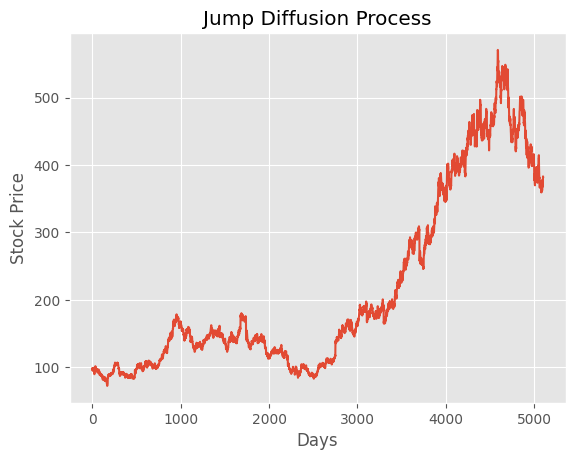

In [80]:
plt.plot(j)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Jump Diffusion Process')

In [81]:
jump_price = pd.DataFrame(j, columns =['Simulation'])

In [82]:
f_log_return(jump_price)

,Simulation,Log Returns
0,98.066404,0.000000
1,95.550344,-2.599157
2,95.570034,0.020605
3,95.684388,0.119583
4,95.443503,-0.252067
...,...,...
5095,368.359719,-0.316319
5096,373.112254,1.281937
5097,380.590324,1.984421
5098,383.131130,0.665377


In [83]:
log_returns = jump_price.iloc[:,1].to_frame()
prices = jump_price.iloc[:,0].to_frame()

#### **Transform Data and Convert to Tensor**

In [84]:
# Rolling window applied to dataframe before converting it to tensor
def rolling_window(data, window=32, stride=1): 
    """
    takes an array and returns rolling window of inputs

    :data: array of values
    :window: size of window you would like each return input
    :stride: do we want to stride inputs 
    
    :return: array of windows
    """    
    x = []
    current = 0
    total = (len(data)/stride)-window
    for i in range(int(total)+1):
        x.append(data[current:current+window])
        current += stride
    return x

data = rolling_window(np.asarray(log_returns))
train_data = np.stack(data, axis=0)

# Convert to tensor
train_data = tf.convert_to_tensor(train_data, np.float32)
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#### **Train the Model**

In [85]:
# Input for the generator: some random noise, called latent data 
EPOCHS = 200
num_examples_to_generate = 16 # maximum value due to plotting 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [86]:
test = [[plot_hist, seed]]

In [87]:
# Global variables for the loss
G_loss = []; D_loss = [];

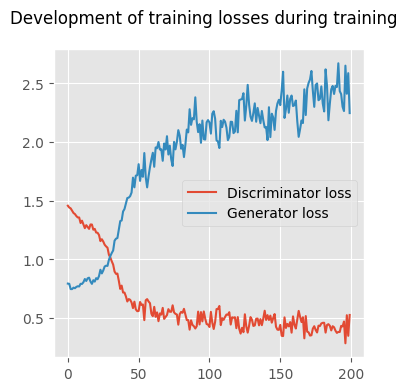

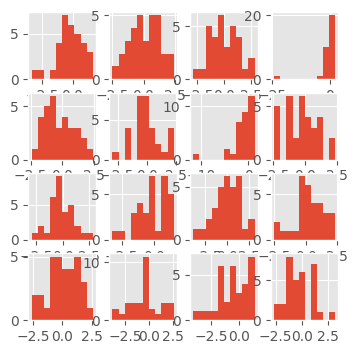

Time for epoch 200 is 3.8555142879486084 sec


In [88]:
# Train the data
train(train_dataset, test, EPOCHS, choice)


#### **Model evaluation**


In [89]:
# Using the trained generator to compute new synthetic data

# Getting generated data
noise = np.random.randn(157,100)
predictions = generator(noise, training=True) # TRAINING TRUE OR FALSE

result = tf.squeeze(predictions) # Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed.
temp = (result.numpy())
generated_data = [item for sublist in temp for item in sublist] # temp is the list getting flattened

df_generated = pd.DataFrame(generated_data,columns=['Generated Data'])
#df_generated.describe()

##### KS-Test
This tests whether 2 samples are drawn from the same distribution. Note that the distribution is assumed to be continuous.

This is the two-sided test, one-sided tests are not implemented. The test uses the two-sided asymptotic Kolmogorov-Smirnov distribution.

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

In [90]:
stats.ks_2samp(log_returns.iloc[:,0],generated_data) # comparing real data to synthetic data

KstestResult(statistic=0.024614399900087423, pvalue=0.09098228142160951, statistic_location=-0.2084789247341306, statistic_sign=1)

##### Plots

##### Generated vs Original log returns

By looking at the log-returns plot from the S&P 500 (figure 7), it is possible to recognize some key patterns. Firstly, the limit in which the returns fluctuate, centered at zero and staying between -10% and 10%. 
Second, the clusters of periods with high volatility and low volatility are usually bundled together, as asserted by the stylized fact of volatility clustering. This pattern is visually identifiable, and it is expected that a good synthetic sample resemble the original data by repeating this patterns of clusters.



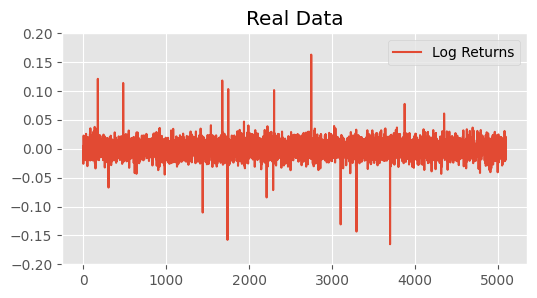

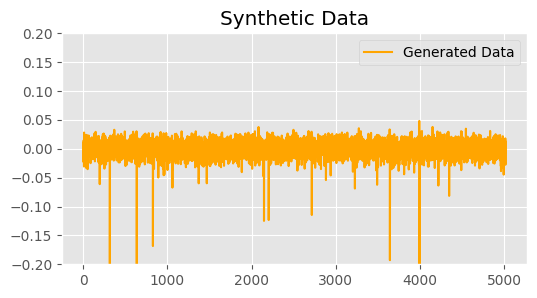

In [91]:
noise = np.random.randn(157,100)
predictions = generator(noise, training=True) # TRAINING TRUE OR FALSE
result = tf.squeeze(predictions) # Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed.
temp = (result.numpy())
generated_data = [item for sublist in temp for item in sublist] # temp is the list getting flattened
df_generated = pd.DataFrame(generated_data,columns=['Generated Data'])


# put them overlapping?
log_returns.div(100).plot(title = "Real Data",ylim=[-0.2,0.2],figsize=(6,3))
df_generated.div(100).plot(title = "Synthetic Data",ylim=[-0.2,0.2],style="orange",figsize=(6,3))

plt.show()

###### Generated vs Original time series
Transforming the generated returns back to prices, for the sake of visualization

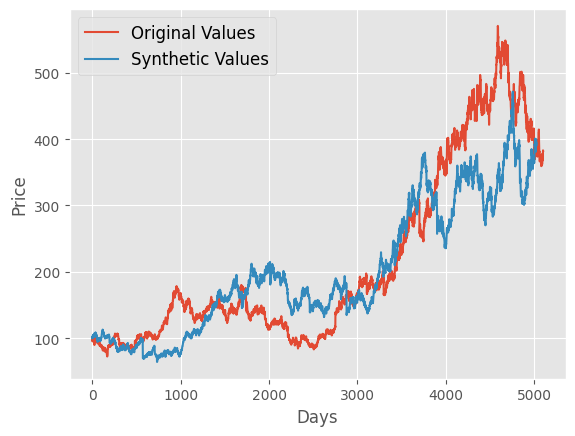

In [92]:
noise = np.random.randn(157,100)
predictions = generator(noise, training=True) # TRAINING TRUE OR FALSE
result = tf.squeeze(predictions) # Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed.
temp = (result.numpy())
generated_data = [item for sublist in temp for item in sublist] # temp is the list getting flattened
df_generated = pd.DataFrame(generated_data,columns=['Generated Data'])

df12 = df_generated.div(100) # divide by 100 to compensate for training input (x100)
df12.iloc[0, 0] = 0
df13 = df12.iloc[:,0].tolist()
price0 = 100 # arbitrary value  1335 on 01.01.2001
df = pd.DataFrame(df13, columns = ['logreturns'])
df["logr_na0"] = df.logreturns.fillna(0)
df['cumlog'] = np.cumsum(df.logr_na0)
df["norm"] = np.exp(df.cumlog)
df["prices_back"] = price0 * df.norm

list_generated = df.iloc[:,4].tolist()
list_original = prices.iloc[:,0].tolist()
plt.plot(list_original, label= "Original Values")
plt.plot(list_generated, label= "Synthetic Values")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend(fontsize=12)
plt.show()


##### Histograms of generated data

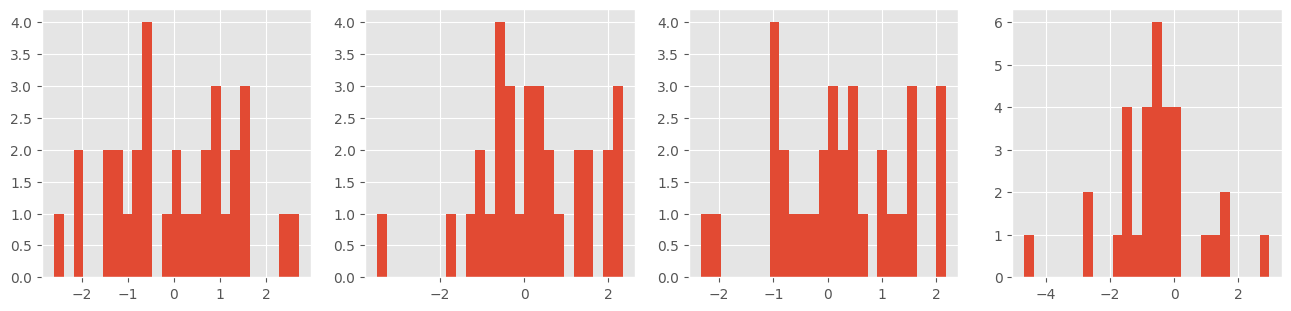

In [93]:
noise_dim = 100
num_examples_to_generate = 4
test_input = tf.random.normal([num_examples_to_generate, noise_dim])
pred = generator(test_input, training=False) # training = False because we are working on the already trained generator
def plot_histogram(predictions):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).

  fig = plt.figure(figsize=(16,16))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # plt.plot(predictions[i, :, 0])
      # plt.axis('off')
      plt.hist(predictions[i, :, 0],bins= 25 ) ## temp

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

plot_histogram(pred)


###### ACF
The auto-correlation plots (ACF) show the similarity between observations as a function of time lags between them, for financial returns the autocorrelation it is expected to be very low, given the stylized fact of linear unpredictability.


(0.0, 2000.0)

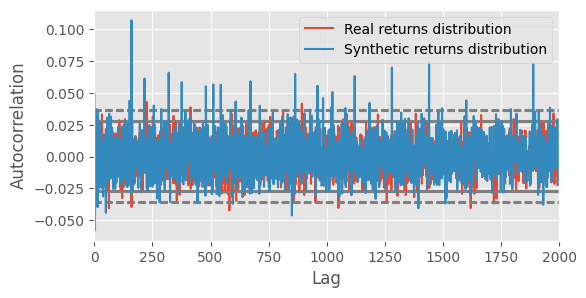

In [94]:
#ACF 
fig, (ax2) = plt.subplots(1, 1, figsize=(6,3))
pd.plotting.autocorrelation_plot(log_returns,label='Real returns distribution', ax=ax2).set_xlim([0, 2000])
pd.plotting.autocorrelation_plot(generated_data, ax=ax2,label='Synthetic returns distribution').set_xlim([0, 2000])

(0.0, 2000.0)

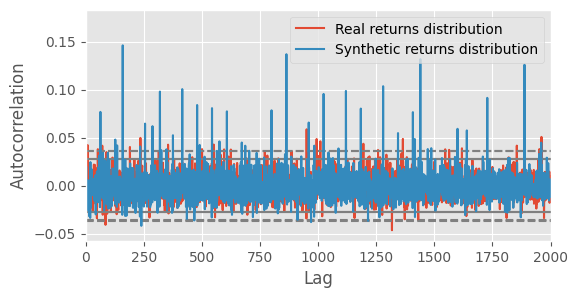

In [95]:
# ACF of absolute returns
fig, (ax2) = plt.subplots(1, 1, figsize=(6,3))
pd.plotting.autocorrelation_plot(np.abs(log_returns),label='Real returns distribution', ax=ax2).set_xlim([0, 2000])
pd.plotting.autocorrelation_plot(np.abs(generated_data), ax=ax2,label='Synthetic returns distribution').set_xlim([0, 2000])


##### PDF
Here the generated and real returns are displayed to analyze their distribution and its characteristic skewness and kurtosis measurements. 

For a GAN to be qualified as good, it is expected that the synthetic returns distribution resemble the shape of the normal distribution (aggregational gaussianity) and the values for skewness and kurtosis should be close to those from real returns.






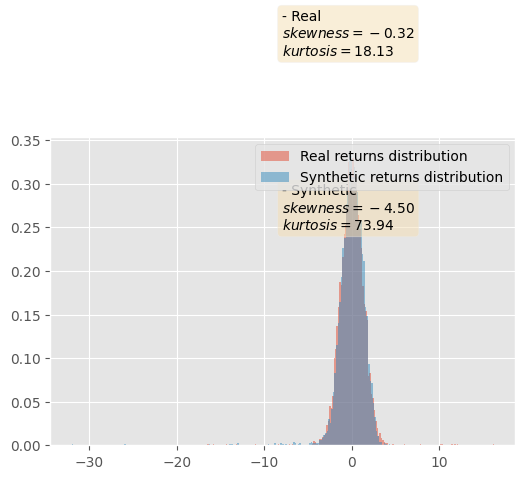

In [96]:
# Comparing the distribution of real and generated (synthetic) data
# PDFs show the probability of observing a value within a specific range
def empirical_pdf(real, syntethic):
  fig, (ax2) = plt.subplots(1, 1, figsize=(6,4))
  ax2.hist(real, density=True, bins=200,alpha=0.5,label='Real returns distribution')
  ax2.hist(syntethic, density=True, bins=200,alpha=0.5,label='Synthetic returns distribution')
  ax2.legend(loc='upper right')

  textstr = '\n'.join((
      r'%s' % ("- Real",),
      # t'abs_metric=%.2f' % abs_metric
      r'$skewness=%.2f$' % (skew(real),),
      r'$kurtosis=%.2f$' % (kurtosis(real),))
  )
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  ax2.text(
      -8, 0.5, textstr,
      fontsize=10,
      verticalalignment='top',
      bbox=props
  )
  textstr = '\n'.join((
      r'%s' % ("- Synthetic",),
      # t'abs_metric=%.2f' % abs_metric
      r'$skewness=%.2f$' % (skew(syntethic),),
      r'$kurtosis=%.2f$' % (kurtosis(syntethic),))
  )
  ax2.text(
      -8, 0.3, textstr, 
      fontsize=10,
      verticalalignment='top',
      bbox=props
  )

empirical_pdf(log_returns.iloc[:,0], generated_data)

###### Skewness and Kurtosis

**Skewness** is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. Here it portrays the gain/loss asymmetry of log returns, where it is expected that the skewness be negative, since it is more common to have large downwards movements in stock prices then the contrary.


**Kurtosis** is a measure that defines how much the tails of a given distribution differ from the tails of a normal distribution. It identifies whether there are extreme values in the tails of a distribution. For returns, large values for kurtosis (heavy tails) are expected, since some low probability events have a large impact on the distribution. This behaviour does not happen in a normal distribution, so returns are expected to have the rough shape of a normal distribution, but with much heavier tails.


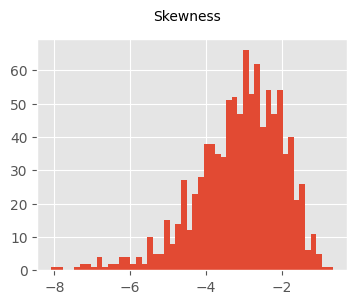

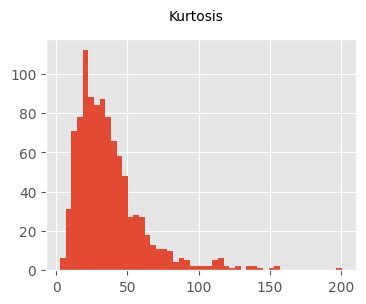

In [97]:
sk = []
flt = []
for i in range(0,1000):
  noise = np.random.randn(111,100)
  result = generator(noise)
  result = tf.squeeze(result)
  temp = (result.numpy())
  generated_data = [item for sublist in temp for item in sublist] 
  sk.append(skew(generated_data))
  flt.append(kurtosis(generated_data))

fig = plt.figure(figsize=(4,3))
fig.suptitle('Skewness', fontsize=10)
plt.hist(sk, bins=50)

fig = plt.figure( figsize=(4,3))
fig.suptitle('Kurtosis', fontsize=10)
plt.hist(flt, bins=50)
plt.show()

### **Diffusion Model**

$\ln \left(S_t\right)=\ln (S)+\int_0^t\left(\mu-\frac{\sigma^2}{2}\right) ds+\int_0^t \sigma d W(s)$.

In [98]:
def diffusion_paths(S, T, r, sigma, steps, Npaths):
    size=(steps,Npaths)
    dt = T/steps 
    geo = np.cumsum(((mu -  sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=size)), axis=0)
    return np.exp(geo)*S


S = 100 # current stock price
T = 20 # time to maturity
mu = 0.1 # drift
steps =255*20 # time steps
Npaths =1 # number of paths to simulate
sigma = 0.2 # annaul standard deviation , for weiner process

gbm = diffusion_paths(S, T, mu, sigma, steps, Npaths)

Text(0.5, 1.0, 'GBM Process')

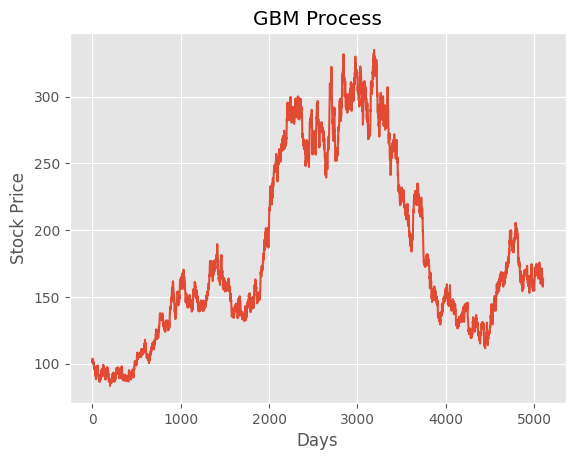

In [99]:
plt.plot(gbm)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('GBM Process')

In [100]:
gbm_price = pd.DataFrame(gbm, columns =['Simulation'])

In [101]:
f_log_return(gbm_price)

,Simulation,Log Returns
0,101.194309,0.000000
1,102.511545,1.293291
2,101.427029,-1.063582
3,102.908847,1.450400
4,103.600989,0.670327
...,...,...
5095,159.307731,0.587599
5096,161.774485,1.536555
5097,157.592226,-2.619245
5098,161.872368,2.679732


In [102]:
log_returns = gbm_price.iloc[:,1].to_frame()
prices = gbm_price.iloc[:,0].to_frame()

#### **Transform Data and Convert to Tensor**

In [103]:
# Rolling window applied to dataframe before converting it to tensor
def rolling_window(data, window=32, stride=1): 
    """
    takes an array and returns rolling window of inputs

    :data: array of values
    :window: size of window you would like each return input
    :stride: do we want to stride inputs 
    
    :return: array of windows
    """    
    x = []
    current = 0
    total = (len(data)/stride)-window
    for i in range(int(total)+1):
        x.append(data[current:current+window])
        current += stride
    return x

data = rolling_window(np.asarray(log_returns))
train_data = np.stack(data, axis=0)

# Convert to tensor
train_data = tf.convert_to_tensor(train_data, np.float32)
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#### **Train the Model**

In [104]:
# Input for the generator: some random noise, called latent data 
EPOCHS = 200
num_examples_to_generate = 16 # maximum value due to plotting 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [105]:
test = [[plot_hist, seed]]

In [106]:
# Global variables for the loss
G_loss = []; D_loss = [];

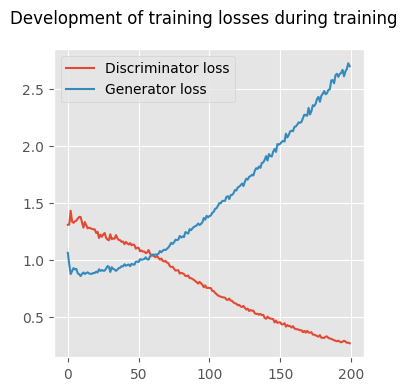

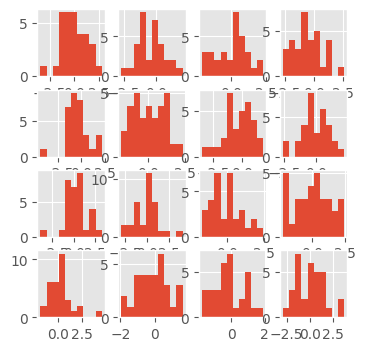

Time for epoch 200 is 3.238145589828491 sec


In [107]:
# Train the data
train(train_dataset, test, EPOCHS, choice)


#### **Model evaluation**


In [108]:
# Using the trained generator to compute new synthetic data

# Getting generated data
noise = np.random.randn(157,100)
predictions = generator(noise, training=True) # TRAINING TRUE OR FALSE

result = tf.squeeze(predictions) # Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed.
temp = (result.numpy())
generated_data = [item for sublist in temp for item in sublist] # temp is the list getting flattened

df_generated = pd.DataFrame(generated_data,columns=['Generated Data'])
#df_generated.describe()

##### KS-Test
This tests whether 2 samples are drawn from the same distribution. Note that the distribution is assumed to be continuous.

This is the two-sided test, one-sided tests are not implemented. The test uses the two-sided asymptotic Kolmogorov-Smirnov distribution.

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

In [109]:
stats.ks_2samp(log_returns.iloc[:,0],generated_data) # comparing real data to synthetic data

KstestResult(statistic=0.014346821531160235, pvalue=0.6668891581868509, statistic_location=1.6416552466288572, statistic_sign=1)

##### Plots

###### Generated vs Original log returns

By looking at the log-returns plot from the S&P 500 (figure 7), it is possible to recognize some key patterns. Firstly, the limit in which the returns fluctuate, centered at zero and staying between -10% and 10%. 
Second, the clusters of periods with high volatility and low volatility are usually bundled together, as asserted by the stylized fact of volatility clustering. This pattern is visually identifiable, and it is expected that a good synthetic sample resemble the original data by repeating this patterns of clusters.



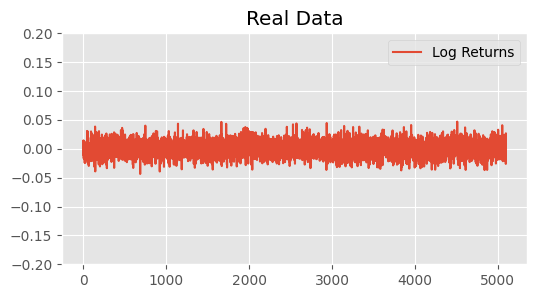

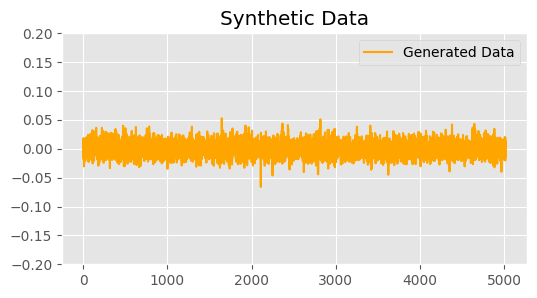

In [110]:
noise = np.random.randn(157,100)
predictions = generator(noise, training=True) # TRAINING TRUE OR FALSE
result = tf.squeeze(predictions) # Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed.
temp = (result.numpy())
generated_data = [item for sublist in temp for item in sublist] # temp is the list getting flattened
df_generated = pd.DataFrame(generated_data,columns=['Generated Data'])


# put them overlapping?
log_returns.div(100).plot(title = "Real Data",ylim=[-0.2,0.2],figsize=(6,3))
df_generated.div(100).plot(title = "Synthetic Data",ylim=[-0.2,0.2],style="orange",figsize=(6,3))

plt.show()

###### Generated vs Original time series
Transforming the generated returns back to prices, for the sake of visualization

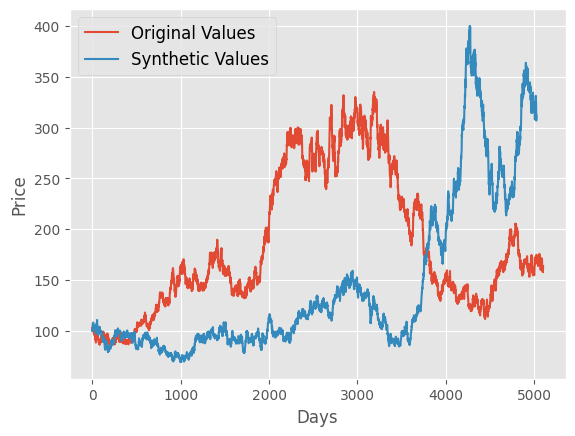

In [111]:
noise = np.random.randn(157,100)
predictions = generator(noise, training=True) # TRAINING TRUE OR FALSE
result = tf.squeeze(predictions) # Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed.
temp = (result.numpy())
generated_data = [item for sublist in temp for item in sublist] # temp is the list getting flattened
df_generated = pd.DataFrame(generated_data,columns=['Generated Data'])

df12 = df_generated.div(100) # divide by 100 to compensate for training input (x100)
df12.iloc[0, 0] = 0
df13 = df12.iloc[:,0].tolist()
price0 = 100 # arbitrary value  1335 on 01.01.2001
df = pd.DataFrame(df13, columns = ['logreturns'])
df["logr_na0"] = df.logreturns.fillna(0)
df['cumlog'] = np.cumsum(df.logr_na0)
df["norm"] = np.exp(df.cumlog)
df["prices_back"] = price0 * df.norm

list_generated = df.iloc[:,4].tolist()
list_original = prices.iloc[:,0].tolist()
plt.plot(list_original, label= "Original Values")
plt.plot(list_generated, label= "Synthetic Values")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend(fontsize=12)
plt.show()


###### Histograms of generated data

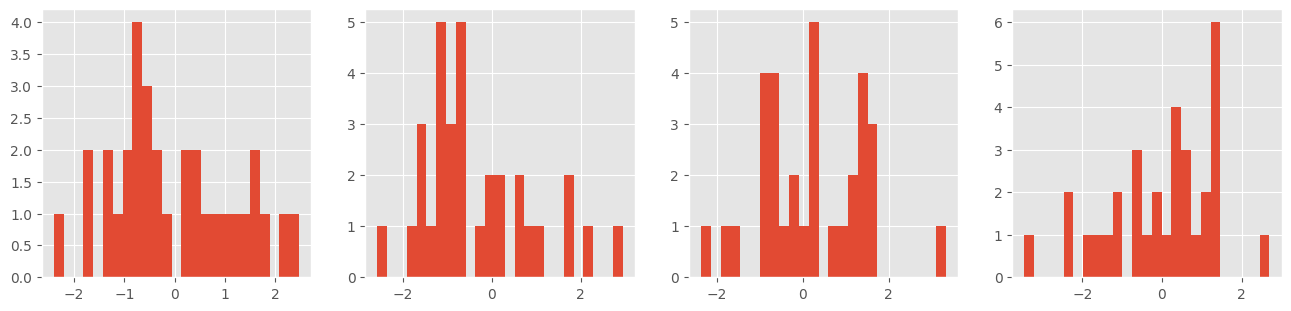

In [112]:
noise_dim = 100
num_examples_to_generate = 4
test_input = tf.random.normal([num_examples_to_generate, noise_dim])
pred = generator(test_input, training=False) # training = False because we are working on the already trained generator
def plot_histogram(predictions):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).

  fig = plt.figure(figsize=(16,16))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # plt.plot(predictions[i, :, 0])
      # plt.axis('off')
      plt.hist(predictions[i, :, 0],bins= 25 ) ## temp

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

plot_histogram(pred)


###### ACF
The auto-correlation plots (ACF) show the similarity between observations as a function of time lags between them, for financial returns the autocorrelation it is expected to be very low, given the stylized fact of linear unpredictability.


(0.0, 2000.0)

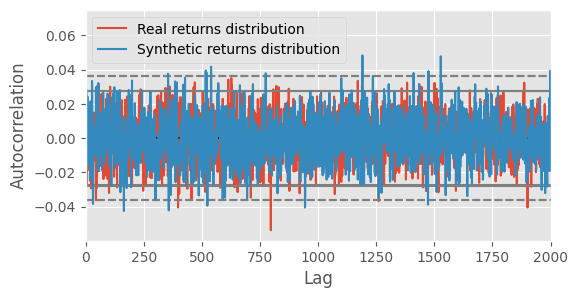

In [113]:
#ACF 
fig, (ax2) = plt.subplots(1, 1, figsize=(6,3))
pd.plotting.autocorrelation_plot(log_returns,label='Real returns distribution', ax=ax2).set_xlim([0, 2000])
pd.plotting.autocorrelation_plot(generated_data, ax=ax2,label='Synthetic returns distribution').set_xlim([0, 2000])

(0.0, 2000.0)

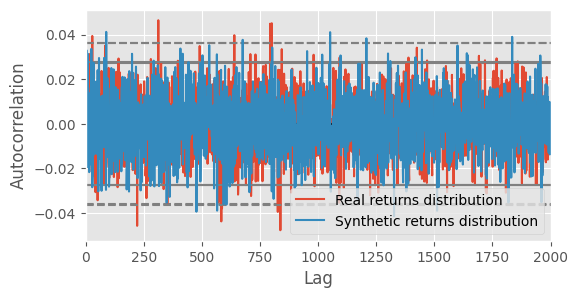

In [114]:
# ACF of absolute returns
fig, (ax2) = plt.subplots(1, 1, figsize=(6,3))
pd.plotting.autocorrelation_plot(np.abs(log_returns),label='Real returns distribution', ax=ax2).set_xlim([0, 2000])
pd.plotting.autocorrelation_plot(np.abs(generated_data), ax=ax2,label='Synthetic returns distribution').set_xlim([0, 2000])


##### PDF
Here the generated and real returns are displayed to analyze their distribution and its characteristic skewness and kurtosis measurements. 

For a GAN to be qualified as good, it is expected that the synthetic returns distribution resemble the shape of the normal distribution (aggregational gaussianity) and the values for skewness and kurtosis should be close to those from real returns.






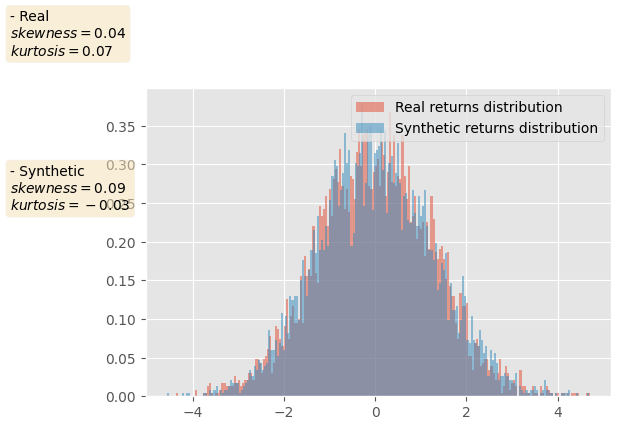

In [115]:
# Comparing the distribution of real and generated (synthetic) data
# PDFs show the probability of observing a value within a specific range
def empirical_pdf(real, syntethic):
  fig, (ax2) = plt.subplots(1, 1, figsize=(6,4))
  ax2.hist(real, density=True, bins=200,alpha=0.5,label='Real returns distribution')
  ax2.hist(syntethic, density=True, bins=200,alpha=0.5,label='Synthetic returns distribution')
  ax2.legend(loc='upper right')

  textstr = '\n'.join((
      r'%s' % ("- Real",),
      # t'abs_metric=%.2f' % abs_metric
      r'$skewness=%.2f$' % (skew(real),),
      r'$kurtosis=%.2f$' % (kurtosis(real),))
  )
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  ax2.text(
      -8, 0.5, textstr,
      fontsize=10,
      verticalalignment='top',
      bbox=props
  )
  textstr = '\n'.join((
      r'%s' % ("- Synthetic",),
      # t'abs_metric=%.2f' % abs_metric
      r'$skewness=%.2f$' % (skew(syntethic),),
      r'$kurtosis=%.2f$' % (kurtosis(syntethic),))
  )
  ax2.text(
      -8, 0.3, textstr, 
      fontsize=10,
      verticalalignment='top',
      bbox=props
  )

empirical_pdf(log_returns.iloc[:,0], generated_data)

##### Skewness and Kurtosis

**Skewness** is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. Here it portrays the gain/loss asymmetry of log returns, where it is expected that the skewness be negative, since it is more common to have large downwards movements in stock prices then the contrary.


**Kurtosis** is a measure that defines how much the tails of a given distribution differ from the tails of a normal distribution. It identifies whether there are extreme values in the tails of a distribution. For returns, large values for kurtosis (heavy tails) are expected, since some low probability events have a large impact on the distribution. This behaviour does not happen in a normal distribution, so returns are expected to have the rough shape of a normal distribution, but with much heavier tails.


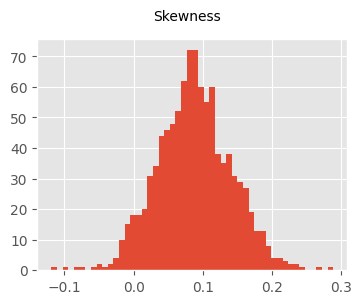

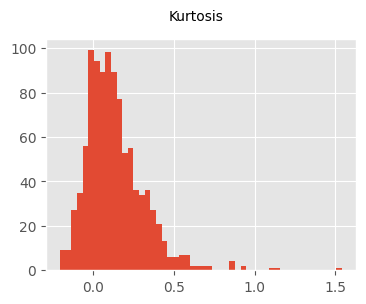

In [116]:
sk = []
flt = []
for i in range(0,1000):
  noise = np.random.randn(111,100)
  result = generator(noise)
  result = tf.squeeze(result)
  temp = (result.numpy())
  generated_data = [item for sublist in temp for item in sublist] 
  sk.append(skew(generated_data))
  flt.append(kurtosis(generated_data))

fig = plt.figure(figsize=(4,3))
fig.suptitle('Skewness', fontsize=10)
plt.hist(sk, bins=50)

fig = plt.figure( figsize=(4,3))
fig.suptitle('Kurtosis', fontsize=10)
plt.hist(flt, bins=50)
plt.show()

### **Real data -- S&P 500 daily**
Use daily data for the S&P 500 index
1) download data from yahoo 
2) do a descriptive analysis of the data
3) Choose one GAN to start with 
3) train the GAN
4) evaluate the outcome

In [117]:
ticker_list = ['^GSPC']
name_list = ['S&P500']
start_date = '2001-01-01'
end_date = '2021-01-01'
ohlc_data = 'Adj Close' 

In [118]:
%pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [119]:
#### Settings
# Imports for data retrieval and analysis
from tensorflow.python.client import device_lib 
from pandas_datareader import data

import yfinance as yf
yf.pdr_override()

#### **Retrieve data from Yahoo finance**




In [120]:
# Downloading the data from Yahooo finance
def download_data(start_date, end_date, ticker_list, name_list):
  """
  Function to enter start and end date for specific security data 

  :param start_date: 'dd-mm-yyyy', string
  :param end_date: 'dd-mm-yyyy', string
  :param ticker_list: list containing yahoo ticker codes as strings
  :param name_list: list containing ticker names as strings

  :return: dataframe of all adjusted closing prices
  """

  closing_data = pd.DataFrame()
  a = 0 

  for name in name_list: 
      closing_data[name_list[a]] = data.get_data_yahoo(ticker_list[a], start=start_date, end=end_date)[ohlc_data]
      a += 1 
      
  return closing_data.fillna(method='ffill')

In [121]:
# Get Log Returns and store in dataframes
prices_returns = download_data(start_date, end_date, ticker_list, name_list)
f_log_return(prices_returns)
log_returns = prices_returns.iloc[:,1].to_frame()
prices = prices_returns.iloc[:,0].to_frame()

[*********************100%***********************]  1 of 1 completed


#### **Transform Data and Convert to Tensor**

In [122]:
# Rolling window applied to dataframe before converting it to tensor
def rolling_window(data, window=32, stride=1): 
    """
    takes an array and returns rolling window of inputs

    :data: array of values
    :window: size of window you would like each return input
    :stride: do we want to stride inputs 
    
    :return: array of windows
    """    
    x = []
    current = 0
    total = (len(data)/stride)-window
    for i in range(int(total)+1):
        x.append(data[current:current+window])
        current += stride
    return x

data = rolling_window(np.asarray(log_returns))
train_data = np.stack(data, axis=0)

# Convert to tensor
train_data = tf.convert_to_tensor(train_data, np.float32)
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#### **Train the Model**

In [123]:
# Input for the generator: some random noise, called latent data 
EPOCHS = 200
num_examples_to_generate = 16 # maximum value due to plotting 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [124]:
test = [[plot_hist, seed]]

In [125]:
# Global variables for the loss
G_loss = []; D_loss = [];

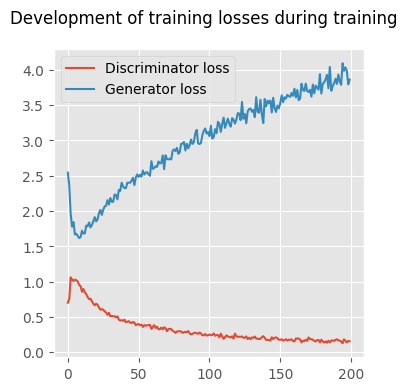

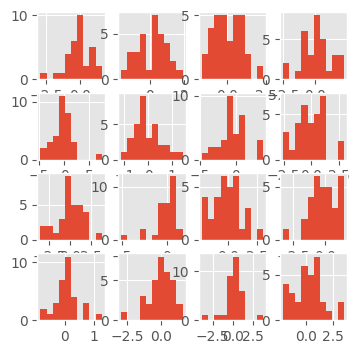

Time for epoch 200 is 3.570665121078491 sec


In [126]:
# Train the data
train(train_dataset, test, EPOCHS, choice)


#### **Model evaluation**


In [127]:
# Using the trained generator to compute new synthetic data

# Getting generated data
noise = np.random.randn(157,100)
predictions = generator(noise, training=True) # TRAINING TRUE OR FALSE

result = tf.squeeze(predictions) # Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed.
temp = (result.numpy())
generated_data = [item for sublist in temp for item in sublist] # temp is the list getting flattened

df_generated = pd.DataFrame(generated_data,columns=['Generated Data'])
#df_generated.describe()

##### KS-Test
This tests whether 2 samples are drawn from the same distribution. Note that the distribution is assumed to be continuous.

This is the two-sided test, one-sided tests are not implemented. The test uses the two-sided asymptotic Kolmogorov-Smirnov distribution.

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

In [128]:
stats.ks_2samp(log_returns.iloc[:,0],generated_data) # comparing real data to synthetic data

KstestResult(statistic=0.02017976669063218, pvalue=0.2525442086105794, statistic_location=0.1872829473473065, statistic_sign=1)

##### Plots

###### Generated vs Original log returns

By looking at the log-returns plot from the S&P 500 (figure 7), it is possible to recognize some key patterns. Firstly, the limit in which the returns fluctuate, centered at zero and staying between -10% and 10%. 
Second, the clusters of periods with high volatility and low volatility are usually bundled together, as asserted by the stylized fact of volatility clustering. This pattern is visually identifiable, and it is expected that a good synthetic sample resemble the original data by repeating this patterns of clusters.



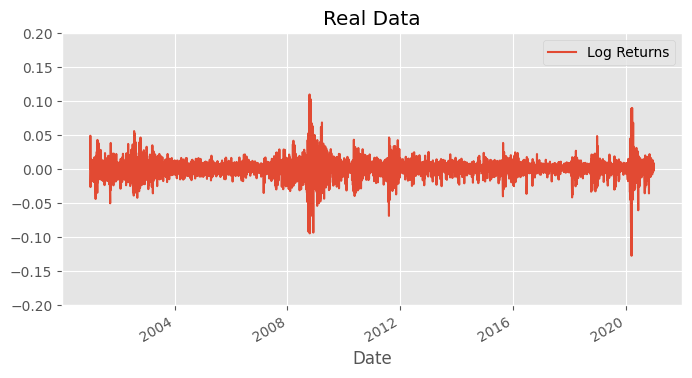

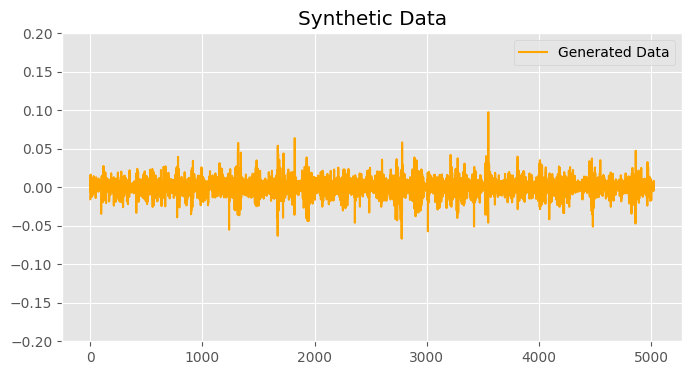

In [129]:
noise = np.random.randn(157,100)
predictions = generator(noise, training=True) # TRAINING TRUE OR FALSE
result = tf.squeeze(predictions) # Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed.
temp = (result.numpy())
generated_data = [item for sublist in temp for item in sublist] # temp is the list getting flattened
df_generated = pd.DataFrame(generated_data,columns=['Generated Data'])


# put them overlapping?
log_returns.div(100).plot(title = "Real Data",ylim=[-0.2,0.2],figsize=(8, 4))
df_generated.div(100).plot(title = "Synthetic Data",ylim=[-0.2,0.2],style="orange",figsize=(8, 4))

plt.show()

###### Generated vs Original time series
Transforming the generated returns back to prices, for the sake of visualization

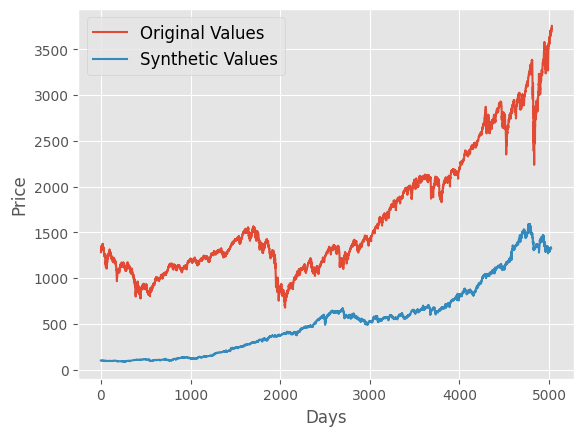

In [130]:
noise = np.random.randn(157,100)
predictions = generator(noise, training=True) # TRAINING TRUE OR FALSE
result = tf.squeeze(predictions) # Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed.
temp = (result.numpy())
generated_data = [item for sublist in temp for item in sublist] # temp is the list getting flattened
df_generated = pd.DataFrame(generated_data,columns=['Generated Data'])

df12 = df_generated.div(100) # divide by 100 to compensate for training input (x100)
df12.iloc[0, 0] = 0
df13 = df12.iloc[:,0].tolist()
price0 = prices.iloc[0,0] # arbitrary value  1335 on 01.01.2001
df = pd.DataFrame(df13, columns = ['logreturns'])
df["logr_na0"] = df.logreturns.fillna(0)
df['cumlog'] = np.cumsum(df.logr_na0)
df["norm"] = np.exp(df.cumlog)
df["prices_back"] = price0 * df.norm

list_generated = df.iloc[:,4].tolist()
list_original = prices.iloc[:,0].tolist()
plt.plot(list_original, label= "Original Values")
plt.plot(list_generated, label= "Synthetic Values")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend(fontsize=12)
plt.show()


###### Histograms of generated data

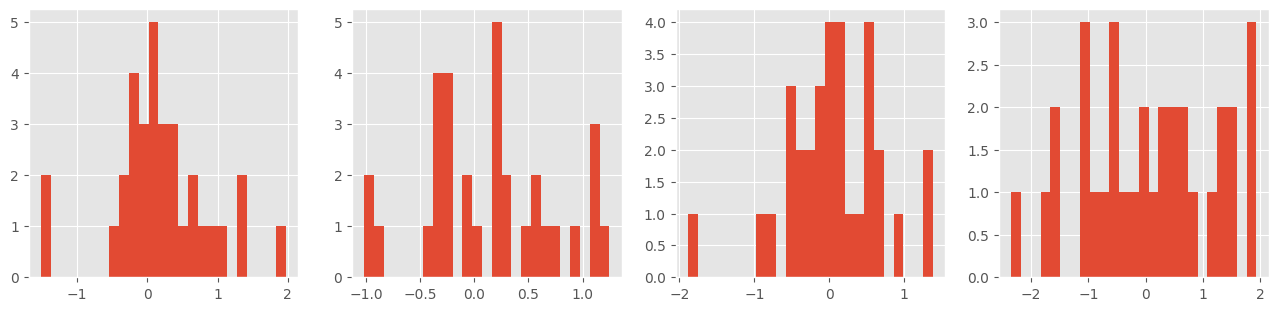

In [131]:
noise_dim = 100
num_examples_to_generate = 4
test_input = tf.random.normal([num_examples_to_generate, noise_dim])
pred = generator(test_input, training=False) # training = False because we are working on the already trained generator
def plot_histogram(predictions):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).

  fig = plt.figure(figsize=(16,16))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # plt.plot(predictions[i, :, 0])
      # plt.axis('off')
      plt.hist(predictions[i, :, 0],bins= 25 ) ## temp

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

plot_histogram(pred)


###### ACF
The auto-correlation plots (ACF) show the similarity between observations as a function of time lags between them, for financial returns the autocorrelation it is expected to be very low, given the stylized fact of linear unpredictability.


(0.0, 2000.0)

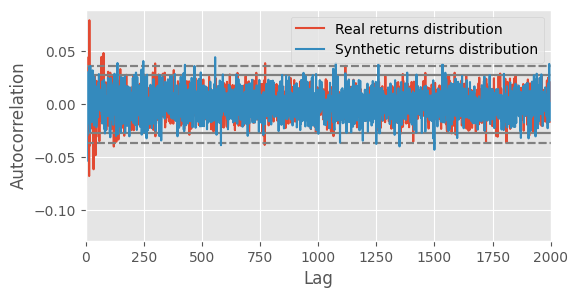

In [132]:
#ACF 
fig, (ax2) = plt.subplots(1, 1, figsize=(6,3))
pd.plotting.autocorrelation_plot(log_returns,label='Real returns distribution', ax=ax2).set_xlim([0, 2000])
pd.plotting.autocorrelation_plot(generated_data, ax=ax2,label='Synthetic returns distribution').set_xlim([0, 2000])

(0.0, 2000.0)

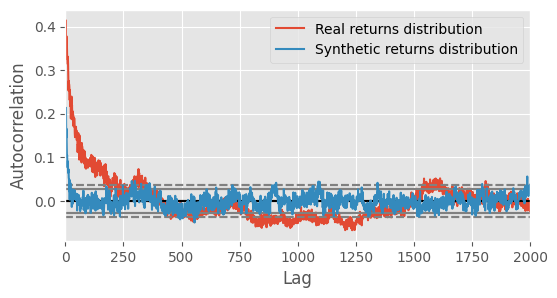

In [133]:
# ACF of absolute returns
fig, (ax2) = plt.subplots(1, 1, figsize=(6,3))
pd.plotting.autocorrelation_plot(np.abs(log_returns),label='Real returns distribution', ax=ax2).set_xlim([0, 2000])
pd.plotting.autocorrelation_plot(np.abs(generated_data), ax=ax2,label='Synthetic returns distribution').set_xlim([0, 2000])


###### PDF
Here the generated and real returns are displayed to analyze their distribution and its characteristic skewness and kurtosis measurements. 

For a GAN to be qualified as good, it is expected that the synthetic returns distribution resemble the shape of the normal distribution (aggregational gaussianity) and the values for skewness and kurtosis should be close to those from real returns.






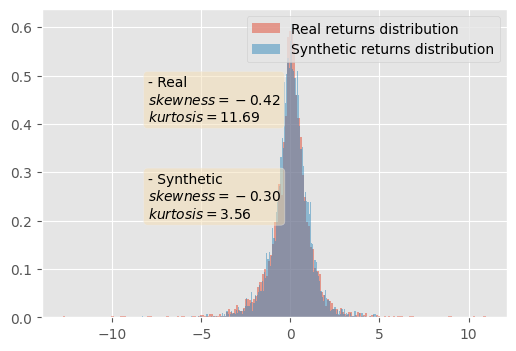

In [134]:
# Comparing the distribution of real and generated (synthetic) data
# PDFs show the probability of observing a value within a specific range
def empirical_pdf(real, syntethic):
  fig, (ax2) = plt.subplots(1, 1, figsize=(6,4))
  ax2.hist(real, density=True, bins=200,alpha=0.5,label='Real returns distribution')
  ax2.hist(syntethic, density=True, bins=200,alpha=0.5,label='Synthetic returns distribution')
  ax2.legend(loc='upper right')

  textstr = '\n'.join((
      r'%s' % ("- Real",),
      # t'abs_metric=%.2f' % abs_metric
      r'$skewness=%.2f$' % (skew(real),),
      r'$kurtosis=%.2f$' % (kurtosis(real),))
  )
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  ax2.text(
      -8, 0.5, textstr,
      fontsize=10,
      verticalalignment='top',
      bbox=props
  )
  textstr = '\n'.join((
      r'%s' % ("- Synthetic",),
      # t'abs_metric=%.2f' % abs_metric
      r'$skewness=%.2f$' % (skew(syntethic),),
      r'$kurtosis=%.2f$' % (kurtosis(syntethic),))
  )
  ax2.text(
      -8, 0.3, textstr, 
      fontsize=10,
      verticalalignment='top',
      bbox=props
  )

empirical_pdf(log_returns.iloc[:,0], generated_data)

##### Skewness and Kurtosis

**Skewness** is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. Here it portrays the gain/loss asymmetry of log returns, where it is expected that the skewness be negative, since it is more common to have large downwards movements in stock prices then the contrary.


**Kurtosis** is a measure that defines how much the tails of a given distribution differ from the tails of a normal distribution. It identifies whether there are extreme values in the tails of a distribution. For returns, large values for kurtosis (heavy tails) are expected, since some low probability events have a large impact on the distribution. This behaviour does not happen in a normal distribution, so returns are expected to have the rough shape of a normal distribution, but with much heavier tails.


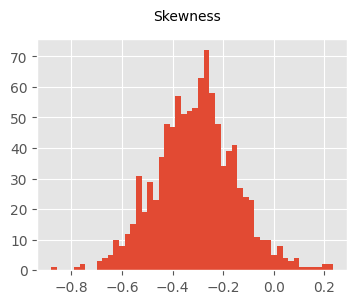

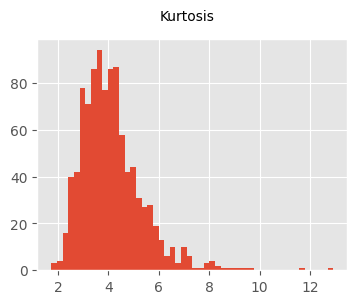

In [135]:
sk = []
flt = []
for i in range(0,1000):
  noise = np.random.randn(111,100)
  result = generator(noise)
  result = tf.squeeze(result)
  temp = (result.numpy())
  generated_data = [item for sublist in temp for item in sublist] 
  sk.append(skew(generated_data))
  flt.append(kurtosis(generated_data))

fig = plt.figure(figsize=(4,3))
fig.suptitle('Skewness', fontsize=10)
plt.hist(sk, bins=50)

fig = plt.figure( figsize=(4,3))
fig.suptitle('Kurtosis', fontsize=10)
plt.hist(flt, bins=50)
plt.show()